In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR = 0.03
EPS = 1e-8
V_MAX = 10.
V_MIN = -10.
N_ATOMS = 51.
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

In [3]:
class CategoricalDuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_atoms)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space * n_atoms)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1, N_ATOMS)
        adv_out = self.adv(out).reshape(out.shape[0], -1, N_ATOMS)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        out = val_out + adv_out - adv_mean
        out = self.log_softmax(out)
        probs = out.exp()

        return probs

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))

    dataloader = DataLoader(train_data,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)
    # like a double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()

        _p_batch = net(_s_batch)
        _weights = _p_batch * net.support
        _q_batch = _weights.sum(dim=2)
        _a_batch = torch.argmax(_q_batch)

        with torch.no_grad():
            _p_batch_tgt = tgt_net(_s_batch)
            _p_best = tgt_p_batch[range(BATCH_SIZE), _a_batch]

        proj_p = projection(_p_best, r_batch, is_done)
        proj_p = torch.tensor(proj_p_np).to(device).float()

        p_batch = net(s_batch)
        p_acting = p_batch[range(BATCH_SIZE), a_batch.data]

        # loss
        eps = np.finfo(np.float32).eps.item()
        loss = -(proj_p * (p_acting + eps).log()).sum(dim=1).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def projection(_p_best, r_batch, is_done):
    proj_p = torch.zeros((BATCH_SIZE, N_ATOMS)).to(device).float()
    for atom in range(N_ATOMS):
        z = torch.minimum(V_MAX, torch.maximum(V_MIN, r_batch + GAMMA * (V_MIN + atom * DELTA_Z)))
        b = (z - V_MIN) / DELTA_Z
        l = torch.floor(b)
        u = torch.ceil(b)

        eq_mask = u == l
        proj_p[eq_mask, l[eq_mask]] += next_p[eq_mask, atom]
        ne_mask = u != l
        proj_p[ne_mask, l[ne_mask]] += next_p[ne_mask, atom] * (u - b)[ne_mask]
        proj_p[ne_mask, u[ne_mask]] += next_p[ne_mask, atom] * (b - l)[ne_mask]

        if dones.any():
            proj_p[dones] = 0.0
            z = np.minimum(V_MAX, np.maximum(V_MIN, rewards[dones]))
            b = (z - V_MIN) / DELTA_Z
            l = np.floor(b).astype(np.int64)
            u = np.ceil(b).astype(np.int64)

            eq_mask = u == l
            eq_dones = dones.copy()
            eq_dones[dones] = eq_mask
            if eq_dones.any():
                proj_p[eq_dones, l] = 1.0

            ne_mask = u != l
            ne_dones = dones.copy()
            ne_dones[dones] = ne_mask
            if ne_dones.any():
                proj_p[ne_dones, l] = (u - b)[ne_mask]
                proj_p[ne_dones, u] = (b - l)[ne_mask]

    return proj_p


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        probs = target_net(state)
        weights = probs * net.support
        q = weights.sum(dim=2)
        action = torch.argmax(q)

    return action.item()

In [5]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
update_frq = int(env.spec.timestep_limit/10)
epsilon = 1.
eps_min = 0.005
eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/5))
num_eval = 10

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = CategoricalDuelingDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
env.spec.max_episode_steps

200

In [7]:
env.spec.reward_threshold

-110.0

In [8]:
env.spec.timestep_limit

200

In [9]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
        env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        epsilon -= epsilon * eps_decay
        epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00

============  Start Learning  ============

  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00
  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3600 steps, reward -200.00
 19 Episode in  3800 steps, reward -200.00
 20 Episode in  4000 steps, reward -200.00
 21 Episode in  4200 steps, reward -200.00
 22 Episode in  4400 steps, reward -200.00
 23 Episo

191 Episode in 36819 steps, reward -114.00
192 Episode in 37019 steps, reward -200.00
193 Episode in 37219 steps, reward -200.00
194 Episode in 37419 steps, reward -200.00
195 Episode in 37619 steps, reward -200.00
196 Episode in 37819 steps, reward -200.00
197 Episode in 38019 steps, reward -200.00
198 Episode in 38219 steps, reward -200.00
199 Episode in 38419 steps, reward -200.00
200 Episode in 38619 steps, reward -200.00


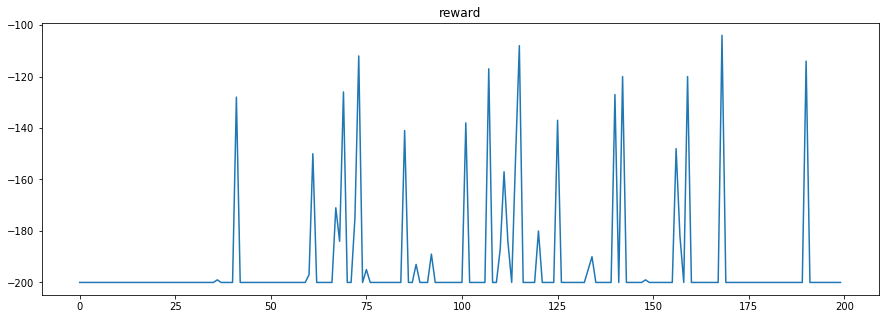

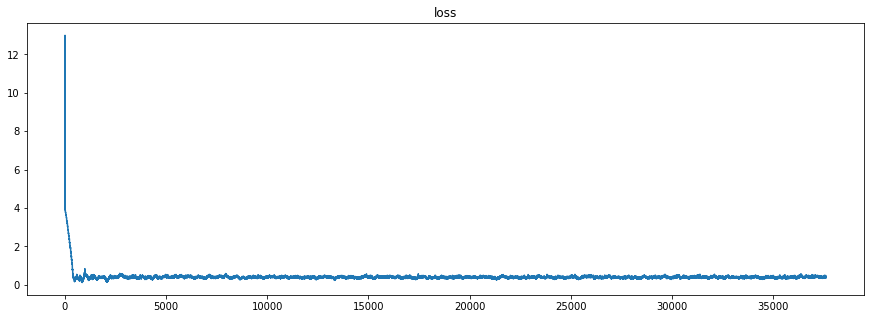

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()